In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR

In [3]:
# Directory setting
DEMO_DIR = os.path.join(RNB_PLANNING_DIR, "src/scripts/demo_202107")
CONFIG_DIR = os.path.join(DEMO_DIR, "configs")
SAVE_DIR = os.path.join(DEMO_DIR, "save_img")
CROP_DIR = os.path.join(DEMO_DIR, "crop_img")
MODEL_DIR = os.path.join(DEMO_DIR, "model_CAD")

# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734

In [4]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP)]
              , connection_list=[False])

connection command:
indy0: False


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,np.pi))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [7]:
from pkg.geometry.geotype import GEOTYPE
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name="indy0_tcp", 
                   dims=(0.061,0.061,0.026), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name="indy0_tcp", 
                   dims=(0.081,0.081,0.046), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name="indy0_tcp", 
                   dims=(0.01,0.01,0.01), center=(0,0,0), rpy=(0,0,0), 
                   color=(1,0,0,0.3), display=True, fixed=True, collision=False, parent="cam")

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.0335), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.0535), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.067), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.087), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

Please create a subscriber to the marker


In [8]:
# Q = [0]*6
# viewpoint.draw_traj_coords([Q])
# gscene.show_pose(crob.home_pose)
# inspect_arguments(gscene.create_safe)
# gscene.add_highlight_axis("ax", "tcp", "indy0_tcp", center=(0,)*3, orientation_mat=np.identity(3))

In [9]:
from math import *

# Set joint value
Q = [-pi/10,-pi/10, -pi/7, pi/20, -pi/3, 0]
crob.joint_move_make_sure(Q)
gscene.show_pose(Q)

# Add coordinate of viewpoint geometry(camera)
viewpoint.draw_traj_coords([Q])

# Transformation from base link to camera
T_v = viewpoint.get_tf(list2dict(Q, gscene.joint_names), "base_link")
print(np.round(T_v, 3))

[[ 0.206 -0.198 -0.958 -0.572]
 [-0.149 -0.974  0.169  0.352]
 [-0.967  0.108 -0.23   0.981]
 [ 0.     0.     0.     1.   ]]


In [10]:
import pyrealsense2 as rs
import cv2
import numpy as np
import open3d as o3d

def camera_streaming():
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()   

    # Set stream resolution
    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    #config.enable_stream(rs.stream.depth, 1024, 768, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
    #config.enable_stream(rs.stream.color, 1920, 1080, rs.format.bgr8, 30)

    # Start streaming
    profile = pipeline.start(config)
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_sensor.set_option(rs.option.visual_preset, 3)
    # Custom = 0, Default = 1, Hand = 2, HighAccuracy = 3, HighDensity = 4, MediumDensity = 5
    depth_scale = depth_sensor.get_depth_scale()
    align_to = rs.stream.depth
    align = rs.align(align_to)

    intrins = []
    try:
        while True:

            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            aligned_frames = align.process(frames)

            aligned_color_frame = aligned_frames.get_color_frame()
            depth_frame = aligned_frames.get_depth_frame()

            #aligned_depth_frame = aligned_frames.get_depth_frame()
            #color_frame = aligned_frames.get_color_frame()
            #depth_frame = frames.get_depth_frame()
            #color_frame = frames.get_color_frame()
            if not depth_frame or not aligned_color_frame:
                continue

            #depth_intrins = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
            depth_intrins = depth_frame.profile.as_video_stream_profile().intrinsics
            color_intrins = aligned_color_frame.profile.as_video_stream_profile().intrinsics
            intrins = depth_intrins
            #print(depth_intrins)
            #print(color_intrins)

            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            color_image = np.asanyarray(aligned_color_frame.get_data())

            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

            depth_colormap_dim = depth_colormap.shape
            color_colormap_dim = color_image.shape

            # If depth and color resolutions are different, resize color image to match depth image for display
            if depth_colormap_dim != color_colormap_dim:
                resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
                images = np.hstack((resized_color_image, depth_colormap))
            else:
                images = np.hstack((color_image, depth_colormap))

            
            # Show images
            cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            cv2.imshow('RealSense', images)
            key = cv2.waitKey(1)

            if (key == 115):
                # If 's' pressed, save color, depth images (far from table)
                cv2.imwrite(SAVE_DIR +'/color.jpg', color_image)
                cv2.imwrite(SAVE_DIR +'/depth.png', depth_image)
            
            if (key == 99):
                # If 'c' pressed, save color, depth images to refine (near from table)
                cv2.imwrite(SAVE_DIR + '/table.jpg', color_image)
                cv2.imwrite(SAVE_DIR + '/table.png', depth_image)

            if (key == 27):
                # If 'esc' pressed, stop streaming and exit
                cv2.destroyAllWindows()
                break

    finally:

        # Stop streaming
        pipeline.stop()
        return intrins, depth_scale


In [11]:
# Start streaming & Save color, depth image
# Return is intrinsic parameter, depth_scale of camera
cam_intrins, d_scale = camera_streaming()

In [12]:
import SharedArray as sa
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

IMG_URI = "shm://color_img"
MASK_URI = "shm://mask_img"
REQ_URI = "shm://request"
RESP_URI = "shm://response"

color_img_p = sa.attach(IMG_URI)
return_img_p = sa.attach(MASK_URI)
request_p = sa.attach(REQ_URI)
resp_p = sa.attach(RESP_URI)

def detect_from_server(image):
    color_img_p[:] = image[:]
    request_p[:] = 1
    while not resp_p[0]:
        time.sleep(0.01)
    resp_p[:] = 0
    return np.copy(return_img_p.astype(np.bool))

In [13]:
# Set color, depth image path
color_img_path = SAVE_DIR + '/color_.jpg'
depth_img_path = SAVE_DIR + '/depth_.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

In [14]:
# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

ValueError: could not broadcast input array from shape (720,1280,3) into shape (480,640,3)

In [15]:
# Crop masking part
vis_mask = (mask_out * 255).astype('uint8')
color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
#cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
#cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)

NameError: name 'mask_out' is not defined

In [16]:
import open3d as o3d
import numpy as np
import cv2
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import subprocess
#subprocess.call(['python3', 'detection.py'])

In [17]:
def preprocessing():
    # Load CAD model of table leg
    model_mesh = o3d.io.read_triangle_mesh(MODEL_DIR + '/table_leg_scaling.STL')
    #model_pcd = model_mesh.sample_points_uniformly(number_of_points=300)

    # Load Depth image to make point clouds
    depth = o3d.io.read_image(CROP_DIR + '/depth_crop.png')
    depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth,
                                            o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                            cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
                                            cam_intrins.ppx, cam_intrins.ppy),
                                            depth_scale = 1/d_scale)
    #depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0)

    # Remove noise points which put very far from camera
    thres = np.linalg.norm(depth_pcd.get_center())
    depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth,
                                            o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                            cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
                                            cam_intrins.ppx, cam_intrins.ppy),
                                            depth_scale = 1/d_scale, depth_trunc = thres * 1.55)
    #depth_pcd = o3d.geometry.PointCloud.create_from_depth_image(depth, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0, depth_trunc = thres * 1.5)

    #o3d.visualization.draw_geometries([depth_pcd])

    # Convert point clouds to numpy array
    xyz_points = np.array(depth_pcd.points)

    # Kmeans Clustering to classify front, back legs of table
    # Ideally, if noise does not exist, then number of cluster is 2
    kmeans = KMeans(n_clusters = 2, random_state = 0)
    kmeans.fit(xyz_points)

    # Re-convert numpy array to point clouds in type of o3d point clouds
    pcd1 = o3d.geometry.PointCloud()
    pcd2 = o3d.geometry.PointCloud()
    #pcd3 = o3d.geometry.PointCloud()
    xyz_1 = np.vstack([xyz_points[kmeans.labels_ == 0,0], xyz_points[kmeans.labels_ == 0,1], xyz_points[kmeans.labels_ == 0,2]])
    xyz_2 = np.vstack([xyz_points[kmeans.labels_ == 1,0], xyz_points[kmeans.labels_ == 1,1], xyz_points[kmeans.labels_ == 1,2]])
    #xyz_3 = np.vstack([xyz_points[kmeans.labels_ == 2,0], xyz_points[kmeans.labels_ == 2,1], xyz_points[kmeans.labels_ == 2,2]])
    pcd1.points = o3d.utility.Vector3dVector(xyz_1.T)
    pcd2.points = o3d.utility.Vector3dVector(xyz_2.T)
    #pcd3.points = o3d.utility.Vector3dVector(xyz_3.T)
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    #o3d.visualization.draw_geometries([pcd1, FOR_origin])
    return model_mesh, pcd1, pcd2

In [18]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    
    FOR_model = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_model.transform(transformation)
    FOR_model.translate(source_temp.get_center()-FOR_model.get_center())
    
    FOR_target = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=target.get_center())
    o3d.visualization.draw_geometries([source_temp, target, FOR_origin, FOR_model, FOR_target])

In [19]:
model_mesh, pcd1, pcd2 = preprocessing()

In [20]:
def compute_ICP(model_mesh, pcd):
    # Compute ICP to align model(source) to obtained point clouds(target)
    target = copy.deepcopy(pcd)
    model_pcd = model_mesh.sample_points_uniformly(number_of_points=int(len(np.array(target.points)*0.8)))
    source = copy.deepcopy(model_pcd)
    #source.translate((-T_Height/2, -T_Depth/2, 0.0), relative=True)
    source_cpy = copy.deepcopy(model_pcd)
    source_cpy.translate((-T_Height, -T_Depth, 0.0), relative=True)

    # Guess Initial Transformation
    center = target.get_center()
    trans_init = np.identity(4)
    trans_init[0:3,3] = center.T
    source_cpy.transform(trans_init)
    trans_init[0:3,3] = source_cpy.get_center().T
    draw_registration_result_original_color(source, target, trans_init)

    print("Apply point-to-point ICP")
    threshold = 0.12
    reg_p2p = o3d.registration.registration_icp(source, target, threshold, trans_init,
            o3d.registration.TransformationEstimationPointToPoint(),
            o3d.registration.ICPConvergenceCriteria(max_iteration = 600000))
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)
    draw_registration_result_original_color(source, target, reg_p2p.transformation)
    ICP_result = reg_p2p.transformation    
    return ICP_result   

In [21]:
ICP_result1 = compute_ICP(model_mesh, pcd1)
ICP_result2 = compute_ICP(model_mesh, pcd2)

FOR_1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#FOR_1.translate((T_Height/2, T_Depth/2, 0.0), relative=True)
FOR_1.transform(ICP_result1)
#FOR_1.translate(source1.get_center()-FOR_1.get_center(), relative=True)
FOR_1.translate((T_Height/2, T_Depth/2, 0.0), relative=True)
#source1.transform(reg_p2p.transformation)

FOR_2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
#FOR_2.translate((T_Height/2, T_Depth/2, 0), relative=True)
FOR_2.transform(ICP_result2)
#FOR_2.translate(source2.get_center()-FOR_2.get_center(), relative=True)
FOR_2.translate((T_Height/2, T_Depth/2, 0), relative=True)
#source2.transform(reg_p2p.transformation)center())

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.184710e-03, and correspondence_set size of 4991
Access transformation to get result.
Transformation is:
[[ 0.99779692 -0.04054529  0.05251089 -1.55800093]
 [ 0.05658045  0.93336264 -0.35444723 -0.3632592 ]
 [-0.03464054  0.35663744  0.93360043  3.06640263]
 [ 0.          0.          0.          1.        ]]
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.674312e-01, inlier_rmse=3.974112e-02, and correspondence_set size of 291
Access transformation to get result.
Transformation is:
[[ 9.92312828e-01 -1.14006728e-01  4.81426740e-02 -1.42192060e+00]
 [ 1.23725872e-01  9.22346446e-01 -3.66017681e-01 -9.15843968e-01]
 [-2.67574606e-03  3.69160535e-01  9.29361792e-01  4.68087679e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


geometry::TriangleMesh with 1134 points and 2240 triangles.

In [22]:
def ransac_plane_fitting(img_path):
    # Find plane through ransac plane fitting
    #depth_raw = o3d.io.read_image("/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/depth.png")
    depth_raw = o3d.io.read_image(img_path)
    depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,
                                            o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                            cam_intrins.height, cam_intrins.fx, cam_intrins.fy,
                                            cam_intrins.ppx, cam_intrins.ppy), depth_scale = 1/d_scale)
    #depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0)

    plane_model, inliers = depth_pcd_raw.segment_plane(distance_threshold=0.01,
                                             ransac_n=8,
                                             num_iterations=2000)
    [a, b, c, d] = plane_model
    print("Coeffs of eq of fitting plane are :")
    print(a,b,c,d)
    return plane_model
    #print(f"Plane equation: {a:.5f}x + {b:.5f}y + {c:.5f}z + {d:.5f} = 0")

In [23]:
img_path = SAVE_DIR +'/depth_.png'
plane_est = ransac_plane_fitting(img_path)

Coeffs of eq of fitting plane are :
(-0.03278097312858208, 0.9444449467669479, 0.32703080944632723, -1.4488030743375666)


In [24]:
def first_pose_obj(FOR_1, FOR_2, plane_model):
    # Estimated Translation of table from camera coordinate
    model_center = (FOR_1.get_center() + FOR_2.get_center())/2
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_obj = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_obj.translate(model_center)
    #o3d.visualization.draw_geometries([depth_pcd, FOR_origin, FOR_obj, FOR_1, FOR_2])

    [a, b, c, d] = plane_model
    
    # z-axis of model(same to plane normal of ground)
    ax_z = np.array([[a], [b], [c]])
    if (b > 0):
        ax_z = -np.array([[a], [b], [c]])

    #a1 = np.array([[1], [0], [(-d-a)/c]])
    #a2 = np.array([[0], [(-d-c)/b], [1]])
    a1 = np.array([[1], [0], [(-d-a)/c]])
    a2 = np.array([[0], [-1], [(-d+b)/c]])
    A = np.asmatrix(np.hstack([a1, a2]))

    # z1, z2를 내적 했는데, 양수면 그냥 하면 되고, 음수면 하나를 reverse해서 진행
    z_axis = np.array([[0], [0], [1]])
    z1 = np.asmatrix(ICP_result1[0:3, 0:3]) * np.asmatrix(z_axis)
    z2 = np.asmatrix(ICP_result2[0:3, 0:3]) * np.asmatrix(z_axis)

    if (np.dot(z1.T, z2) > 0):
        # Projection to plane
        ax_y1 = A * np.linalg.inv(A.T*A) * A.T * z1
        ax_y2 = A * np.linalg.inv(A.T*A) * A.T * z2
        ax_y = (ax_y1 + ax_y2)/2
    else:
        z2 = -z2
        # Projection to plane
        ax_y1 = A * np.linalg.inv(A.T*A) * A.T * z1
        ax_y2 = A * np.linalg.inv(A.T*A) * A.T * z2
        ax_y = (ax_y1 + ax_y2)/2


    # Find last axis through cross product
    ax_x = np.cross(ax_y.T, ax_z.T).T

    # Normalize
    ax_x = ax_x / np.linalg.norm(ax_x)
    ax_y = ax_y / np.linalg.norm(ax_y)
    ax_z = ax_z / np.linalg.norm(ax_z)
    #ax_y = np.cross(ax_z.T, ax_x.T).T

    # Estimated Orientation of table from camera coordinate
    model_rotation_mtx = np.hstack([ax_x, ax_y, ax_z])
    #print(model_rotation_mtx)
    #print(np.dot(ax_x.T, ax_z))
    #print(np.dot(ax_x.T, ax_y))
    #print(np.dot(ax_y.T, ax_z))

    #trans_z = np.array([0, 0, depth/2])
    FOR_final = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_final.translate(model_center)
    FOR_final.rotate(model_rotation_mtx)
    #FOR_final.translate(trans_z, relative=True)
    FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    #o3d.visualization.draw_geometries([depth_pcd, FOR_origin, FOR_final])

    print("========== Found 6DoF Pose of table ==========")
    print("Rotation matrix is :")
    print(model_rotation_mtx)
    print("\nTranslation is :")
    print(model_center)
    T_co = np.identity(4)
    T_co[0:3,0:3] = model_rotation_mtx
    T_co[0:3,3] = model_center.T
    print("\nHomogeneous Transformation(Cam to Table) is :")
    print(T_co)
    
    return T_co

In [25]:
T_co = first_pose_obj(FOR_1, FOR_2, plane_est)

========== Found 6DoF Pose of table ==========
Rotation matrix is :
[[ 0.99743319 -0.06801297  0.03278097]
 [ 0.01007282 -0.17629035 -0.94444495]
 [ 0.07089119  0.98198572 -0.32703081]]

Translation is :
[-1.08995667 -0.26745295  3.88352824]

Homogeneous Transformation(Cam to Table) is :
[[ 0.99743319 -0.06801297  0.03278097 -1.08995667]
 [ 0.01007282 -0.17629035 -0.94444495 -0.26745295]
 [ 0.07089119  0.98198572 -0.32703081  3.88352824]
 [ 0.          0.          0.          1.        ]]


In [26]:
# Transformation from robot base to table
T_bo = np.asmatrix(T_v) * np.asmatrix(T_co)
print("Homogeneous Transformation(Base to Table) is :")
print(T_bo)
center_p = T_bo[0:3,3].T

Homogeneous Transformation(Base to Table) is :
[[ 0.13507169 -0.92034153  0.50688383 -4.46558778]
 [-0.14647793  0.34782915  0.86001456  1.43100604]
 [-0.9799489  -0.17884747 -0.05868417  1.11447614]
 [ 0.          0.          0.          1.        ]]


In [27]:
# Transformation from mobile base to robot arm base (coordinate 알려줘야 적을듯)
#T_mb = 
#T_mo = T_mb * T_bo
print("Homogeneous Transformation(Mobile Base to Table) is :")
#print(T_mo)

Homogeneous Transformation(Mobile Base to Table) is :


In [28]:
# Convert Rotation matrix to roll-pitch-yaw(ZYX Euler angle)
R = T_bo[0:3,0:3]
sy = sqrt(R[0,0]**2 + R[1,0]**2)

if sy > 0.000001:
    x = atan2(R[2,1] , R[2,2])
    y = atan2(-R[2,0], sy)
    z = atan2(R[1,0], R[0,0])
else:
    x = atan2(-R[1,2], R[1,1])
    y = atan2(-R[2,0], sy)
    z = 0
rpy_p = np.asarray(list(reversed(np.asarray([z,y,x]))))

In [29]:
# geometry 추가
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=(0.785,1.80,0.735), center=center_p, rpy=rpy_p, 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

In [30]:
# 모서리부분 근접 촬영
_, _ = camera_streaming()
print(cam_intrins.fx, cam_intrins.fy, cam_intrins.ppx, cam_intrins.ppy)

(464.578125, 464.57421875, 351.5234375, 238.875)


In [31]:
def line_detect(img_path):
    #Ransac Plane Fitting
    #depth_img = cv2.imread('/home/jhkim/Swin-Transformer-Object-Detection/test_table.png',
    #                                                               flags=cv2.IMREAD_UNCHANGED)
    #depth_raw = o3d.io.read_image('/home/jhkim/Swin-Transformer-Object-Detection/test_table.png')
    #depth_img = cv2.imread('/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/table.png',
    #                                                              flags=cv2.IMREAD_UNCHANGED)
    #depth_raw = o3d.io.read_image('/home/jhkim/Projects/rnb-planning/src/scripts/demo_202107/save_img/table.png')
    depth_img = cv2.imread(img_path, flags=cv2.IMREAD_UNCHANGED)
    depth_raw = o3d.io.read_image(img_path) 
    depth_pcd_raw= o3d.geometry.PointCloud.create_from_depth_image(depth_raw,
                                        o3d.camera.PinholeCameraIntrinsic(cam_intrins.width,
                                        cam_intrins.height,cam_intrins.fx, cam_intrins.fy,
                                        cam_intrins.ppx, cam_intrins.ppy), depth_scale = 1/d_scale,
                                                                                   depth_trunc = 1)
    #depth_pcd_raw = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, o3d.camera.PinholeCameraIntrinsic(640, 480, 
    #                                                                                                  461.734375, 462.06640625, 
    #                                                                                                  350.4140625, 244.541015625), depth_scale = 4000.0, depth_trunc = 1)


    plane_model, inliers = depth_pcd_raw.segment_plane(distance_threshold=0.001,
                                             ransac_n=8,
                                             num_iterations=1000)
    [a, b, c, d] = plane_model
    print("Coeffs of eq of fitting plane are :")
    print(a,b,c,d)

    p_inliers = depth_pcd_raw.points[0]
    for i in range(len(inliers)-1):
        p_inliers = np.vstack([p_inliers, depth_pcd_raw.points[i+1]])

    pcd_inliers = o3d.geometry.PointCloud()
    pcd_inliers.points = o3d.utility.Vector3dVector(p_inliers)
    #o3d.visualization.draw_geometries([pcd_inliers])

    # Generate Binary mask image to detect line and edge of table
    depth_make = np.zeros([480,640], dtype='uint8')
    for i in range(len(inliers)):
        u = int((p_inliers[i][0]/p_inliers[i][2]) * cam_intrins.fx + cam_intrins.ppx)
        v = int((p_inliers[i][1]/p_inliers[i][2]) * cam_intrins.fy + cam_intrins.ppy)
        depth_make[v][u] = 255
    #plt.imshow(depth_make)
    
    # Closing image
    kernel = np.ones((11,11), np.uint8)
    #depth_make_open = cv2.morphologyEx(depth_make, cv2.MORPH_OPEN, kernel)
    depth_make_close = cv2.morphologyEx(depth_make, cv2.MORPH_CLOSE, kernel)
    plt.imshow(depth_make_close)
    
    # Canny Edge Detection & Probabilistic Hough Line Detection
    # Parameter(threshold value) shoud be tuned for our Demo Environment
    tmp = cv2.cvtColor(depth_make_close, cv2.COLOR_GRAY2RGB)
    canny = cv2.Canny(depth_make_close, 450, 1000, apertureSize = 5, L2gradient = True)
    lines = cv2.HoughLinesP(canny, 1, np.pi/180, 50, minLineLength = 13, maxLineGap = 40)

    # Check the line detection result
    for i in lines:
        cv2.line(tmp, (i[0][0], i[0][1]), (i[0][2], i[0][3]), (0, 0, 255), 2)

    cv2.imshow("Line Detect", tmp)
    cv2.imshow("Canny", canny)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return depth_img, lines, plane_model

Coeffs of eq of fitting plane are :
(-0.026615157292016602, 0.6225086441746293, 0.7821602274024076, -0.595054375584091)


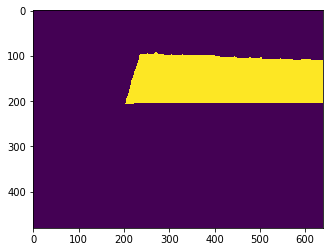

In [32]:
img_path = SAVE_DIR + '/table_.png'
depth_img, lines, plane_est = line_detect(img_path)

In [33]:
lines.shape

(5, 1, 4)

In [34]:
def similarity2line1(u_j, v_j, u_list, v_list):
    u1 = u_list[0]
    u2 = u_list[1]
    v1 = v_list[0]
    v2 = v_list[1]
    value = (v_j-v1)(u1-u2) - (v1-v2)(u_j-u1)
    return abs(value)

In [35]:
def similarity2line2(u_j, v_j, u_list, v_list):
    u1 = u_list[0]
    u3 = u_list[2]
    v1 = v_list[0]
    v3 = v_list[2]
    value = (v_j-v1)(u3-u1) - (v3-v1)(u_J-u1)
    return abs(value)

In [36]:
# 꼭짓점 4개의 좌표가 온다고 할 때,
# 아니다.사진 찍은 위치의 코너를 알고 있으면 좌표 세개로부터 직선 두개 결정
# stack하는 순서는 찍은 코너를 첫번째로 stacking
# point 3개가 넘어온다 생각하고, pixel 좌표로 변환한 거를 저장하는 u,v list

# test
p1 = np.array([0.5,0.5,T_Depth])
p2 = np.array([0.5,0.5+T_Width,T_Depth])
p3 = np.array([0.5+T_Height,0.5,T_Depth])
p = np.vstack([p1, p2, p3])

In [37]:
def edge_detect(depth_img, p):
    # Convert points w.r.t pixel coordinate
    u_list = []
    v_list = []
    for i in range(3):
        u_list.append(int((p[i][0]/p[i][2]) * cam_intrins.fx + cam_intrins.ppx))
        v_list.append(int((p[i][1]/p[i][2]) * cam_intrins.fy + cam_intrins.ppy))

    # Find similar lines
    metric1 = []
    metric2 = []
    for i in lines:
        xe, ye, xs, ys = i[0][0], i[0][1], i[0][2], i[0][3]
        result1 = []
        result2 = []
        for u_j in range(xs, xe):
            v_j = (ye-ys)/(xe-xs) * (u_j-xs) + ys 
            #u_j = int((xe-xs)/(ye-ys) * (v_j-ys) + xs)
            result1.append(similarity2line1(u_j, v_j, u_list, v_list))
            result2.append(similarity2line2(u_j, v_j, u_list, v_list))

        metric1.append(np.mean(result1))
        metric2.append(np.mean(result2))

    index1 = metric1.index(min(metric1))
    index2 = metric2.index(min(metric2))
    #print(index1, index2)


    # Start, End Points of lines
    xe, ye, xs, ys = lines[index1][0]
    xe_, ye_, xs_, ys_ = lines[index2][0]
    #print(xe, ye, xs, ys)
    #print(xe_, ye_, xs_, ys_)

    # Two vectors which represent the line
    z1 = (depth_img[ys][xs]/65535.0)/(d_scale*1000)
    x1 = (xs - cam_intrins.ppx) * z1/cam_intrins.fx
    y1 = (ys - cam_intrins.ppy) * z1/cam_intrins.fy
    p1 = np.asmatrix(np.array([[x1],[y1],[z1]]))

    z2 = (depth_img[ye][xe]/65535.0)/(d_scale*1000)
    x2 = (xe - cam_intrins.ppx) * z2/cam_intrins.fx
    y2 = (ye - cam_intrins.ppy) * z2/cam_intrins.fy
    p2 = np.asmatrix(np.array([[x2],[y2],[z2]]))

    z1_ = (depth_img[ys_][xs_]/65535.0)/(d_scale*1000)
    x1_ = (xs_ - cam_intrins.ppx) * z1_/cam_intrins.fx
    y1_ = (ys_ - cam_intrins.ppy) * z1_/cam_intrins.fy
    p1_ = np.asmatrix(np.array([[x1_],[y1_],[z1_]]))

    z2_ = (depth_img[ye_][xe_]/65535.0)/(d_scale*1000)
    x2_ = (xs_ - cam_intrins.ppx) * z2_/cam_intrins.fx
    y2_ = (ys_ - cam_intrins.ppy) * z2_/cam_intrins.fy
    p2_ = np.asmatrix(np.array([[x2_],[y2_],[z2_]]))

    line_vec1 = p2 - p1
    line_vec2 = p2_ - p1_
    ax_x = line_vec1
    ax_y = line_vec2

    # Detect Edge point of table
    edge_cand1 = (p1+p1_)/2
    edge_cand2 = (p1+p2_)/2
    edge_cand3 = (p2+p1_)/2
    edge_cand4 = (p2+p2_)/2

    dist_cand1 = np.linalg.norm(p1 - p1_)
    dist_cand2 = np.linalg.norm(p1 - p2_)
    dist_cand3 = np.linalg.norm(p2 - p1_)
    dist_cand4 = np.linalg.norm(p2 - p2_)

    edge_list = [dist_cand1, dist_cand2, dist_cand3, dist_cand4]
    idx = edge_list.index(min(edge_list)) + 1

    edge = edge_cand4
    if (idx == 1):
        edge = edge_cand1

    if (idx == 2):
        edge = edge_cand2

    if (idx == 3):
        edge = edge_cand3

    if (idx == 4):
        edge = edge_cand4
    
    return edge, ax_x, ax_y

In [38]:
edge, ax_x, ax_y = edge_detect(depth_img, p)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
##### Testing용 #####
T_co_new = np.identity(4)
T_co_new[0:3,0] = np.array([0,1,0]).T
T_co_new[0:3,1] = np.array([-1,0,0]).T
######################

In [40]:
def pose_obj(plane_model, edge, ax_x, ax_y, T_co_new):
    a, b, c, d = plane_model
    surface_normal = np.array([[a], [b], [c]])
    #surface_normal = np.cross(line_v1.T, line_v2.T) 

    # ax_x, ax_y가 line으로부터 땄는데, 반드시 수직하다는 보장 있나..? 근접샷에서 딴 거니까 정확하다고 그냥 생각해야하나
    # normalize 
    if (np.dot(T_co_new[0:3,0].T, ax_x) < 0):
        ax_x = -ax_x

    if (np.dot(T_co_new[0:3,1].T, ax_y) < 0):
        ax_y = -ax_y

    ax_z = surface_normal/np.linalg.norm(surface_normal)
    ax_x = ax_x/np.linalg.norm(ax_x)
    ax_y = ax_y/np.linalg.norm(ax_y)
    #print(np.dot(ax_z.T,ax_x))
    #print(np.dot(ax_x.T,ax_y))
    #print(np.dot(ax_y.T,ax_z))


    # Estimated Orientation of table from camera coordinate
    model_rotation_mtx = np.hstack([ax_x, ax_y, ax_z])

    #estimated_box = o3d.geometry.TriangleMesh.create_box(width=T_Width, height=T_Height, depth=T_Depth)
    #estimated_box.translate(edge)
    #estimated_box.rotate(model_rotation_mtx)
    FOR_box = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.15, origin=[0,0,0])
    FOR_box.translate(edge)
    FOR_box.rotate(model_rotation_mtx)
    #FOR_box.translate((-T_Height/2, T_Width/2, -T_Depth/2), relative=True)

    T_co_result = np.identity(4)
    T_co_result[0:3,0:3] = model_rotation_mtx
    T_co_result[0:3,3] = FOR_box.get_center().T
    #model_new_center = (T_co_new[0:3,3] + FOR_box.get_center())/2

    print("\nHomogeneous Transformation(Cam to Table) is :")
    print(T_co_result)
    return T_co_result

In [41]:
T_co_result = pose_obj(plane_est, edge, ax_x, ax_y, T_co_new)


Homogeneous Transformation(Cam to Table) is :
[[-0.99931653 -0.52512772 -0.02661516  0.13276524]
 [ 0.00276719  0.063706    0.62250864 -0.00741477]
 [-0.03686213 -0.84863562  0.78216023  0.20978076]
 [ 0.          0.          0.          1.        ]]
